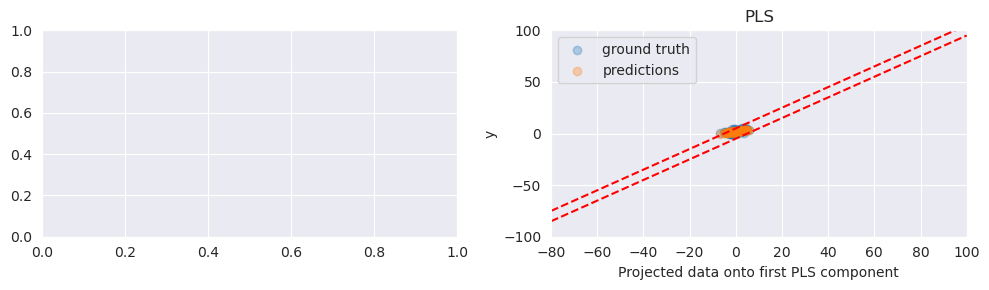

PLS r-squared -39.683


In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler

# Read the experimental data
experimental = pd.read_excel('/home/nick/PycharmProjects/Engineering_EKB/data/experimental_data.xlsx', sheet_name="seq vs screen sorted")

# Select the target variable
fold_increase_30 = experimental['30 without 50C pre-incubation,\ninitial rate @ 25C']

# Read the molecular data
molecular_data = pd.read_excel('/home/nick/PycharmProjects/Engineering_EKB/data/Dataset_Nick_heading.xlsx')

# Merge the target variable with the molecular data
molecular_data = molecular_data.join(fold_increase_30)

# Define a function to remove outliers using Chauvenet's criterion
def remove_outliers_chauvenet(dataframe, column):
    n = dataframe.shape[0]
    mean = dataframe[column].mean()
    std_dev = dataframe[column].std()
    z_scores = (dataframe[column] - mean) / std_dev
    probability = 0.5 / n  # Chauvenet's criterion threshold
    return dataframe[stats.norm.sf(abs(z_scores)) > probability]

# Remove outliers from the merged dataset using Chauvenet's criterion
molecular_data_cleaned = remove_outliers_chauvenet(molecular_data, '30 without 50C pre-incubation,\ninitial rate @ 25C')

# Check if there are enough samples after removing outliers
if molecular_data_cleaned.shape[0] < 2:
    raise ValueError("Not enough samples remaining after removing outliers.")

# Separate the features (X) and target variable (y)
X = molecular_data_cleaned.loc[:, molecular_data_cleaned.columns != '30 without 50C pre-incubation,\ninitial rate @ 25C']
y = molecular_data_cleaned['30 without 50C pre-incubation,\ninitial rate @ 25C']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

from sklearn.cross_decomposition import PLSRegression
pls = PLSRegression(n_components=1)
pls.fit(X_train, y_train)

# Plot the results
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
scatter = axes[1].scatter(pls.transform(X_test).flatten(), y_test, alpha=.3, label='ground truth')
axes[1].scatter(pls.transform(X_test).flatten(), pls.predict(X_test), alpha=.3, label='predictions')
axes[1].set(xlabel='Projected data onto first PLS component', ylabel='y', title='PLS')
axes[1].legend()

# Manually adjust the axis limits for the plot
x_lower_bound = -80
x_upper_bound = 100
y_lower_bound = -100
y_upper_bound = 100
axes[1].set_xlim(x_lower_bound, x_upper_bound)
axes[1].set_ylim(y_lower_bound, y_upper_bound)

# Add a line to highlight the points where the predicted and true values are close
threshold = 5
axes[1].plot([x_lower_bound, x_upper_bound], [x_lower_bound + threshold, x_upper_bound + threshold], color='red', linestyle='--')
axes[1].plot([x_lower_bound, x_upper_bound], [x_lower_bound - threshold, x_upper_bound - threshold], color='red', linestyle='--')

plt.tight_layout()
plt.show()

# Calculate PLS r-squared
print(f"PLS r-squared {pls.score(X_test, y_test):.3f}")